# RNN을 이용한 주가 예측

finance-datareader가 설치가 되지 않은 상황이라면 설치해줍니다.

In [1]:
!pip install -U finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 2.1 MB/s eta 0:00:00


## 1. 순환 신경망

**사람이 대화를 할 때는 이전의 맥락을 이해하면서 단어를 해석합니다.** 예를 들어서 왼쪽의 굵은 표시를 한 문장을 여러분들은 '사람이\~' 다음에 '대화를\~'을 읽었고, 그 다음에는 '할 때는\~'을 순차적으로 읽기 시작해서 앞에서부터 뒤에서까지의 전체적인 문맥을 이해해나가면서 '\~해석합니다' 까지 읽었습니다. 즉, 여러분들은 문장을 좌측에서 우측으로 순차적으로 이전의 맥락을 이해하면서 문장을 읽은 것이죠.

사람처럼 딥 러닝도 시간 개념을 넣어서 순차적으로, 순서대로 데이터를 입력을 받아서 데이터의 전체적인 흐름을 이해하도록 하고 싶었습니다. 그렇게 만들어진 것이 RNN입니다. RNN은 그래서 시간 개념이 들어가있는 데이터. 좀 더 어려운 용어로는 시계열 데이터를 다루는 데에 적합합니다. 크게 예시가 두 가지가 있습니다.

*    **텍스트 데이터** : 예를 들어 메일이 왔는데 사람이 이메일의 본문을 읽고 스팸 메일인지 정상 메일인지 판단하는 것은 귀찮은 일입니다. RNN에게 메일이 올 때마다 본문을 읽어보라고 하면 RNN은 단어를 순차적으로 사람처럼 읽은 뒤에 스팸 메일이면 사람이 보기 전에 그냥 휴지통으로 넣도록 **스팸 메일 분류기를 RNN으로 만들 수도 있을 것입니다.**

*    **주가 데이터** : 6월 1일의 주가 데이터, 6월 2일의 주가 데이터, 6월 3일의 주가 데이터를 순차적으로 입력으로 넣은 뒤에 RNN에게 묻습니다. 6월 4일의 주가는 어떻게 될 것 같아? RNN은 이전의 맥락. 여기서는 맥락이라는 표현보다는 주가의 흐름이라는 표현이 더 알맞을텐데, RNN은 이전의 주가의 흐름으로부터 다음 주가가 어떻게 될 것인지를 예측하는 것이죠.

이번에는 일단 주가 데이터를 다루는 것에 집중합니다.

### 1-1. 순환 신경망 RNN의 구조
순환 신경망에서는 뉴런을 셀(Cell)이라고 부르는데, 순환 신경망에서 순환(recurrent)한다는 것은 아래 그림에서 보듯이 이전의 데이터를 통해 학습된 셀의 상태 정보가 다음 데이터를 이용하여 학습시킬 때 다시 사용된다는 의미입니다. 따라서, 순환 신경망은 시계열 데이터를 처리할 때 적합하며, 아래 그림처럼 펼쳐서 나타낼 수 있습니다.

<img src='https://wikidocs.net/images/page/173005/rnn.png'>

**수식은 다음과 같습니다.**

$h_t=활성화 함수(W(h_{t-1,x_t}+b)$

$h_1=활성화 함수(W(h_{0,x_1}+b)$


셀에서 만들어지는 출력인 $h_t$를 은닉 상태라고 합니다.
$W$와
$b$는 선형 회귀의 수식($y=W_x+b$)과 마찬가지로 모델을 학습시키면 최적의 값으로 수렴하는 가중치와 편향입니다.

위의 그림에서 $x_0$는 첫번째 입력, $x_1$은 두번째 입력, $x_2$ 세번째 입력, 그리고 계속해서 입력이 되다가(...으로 표현) 언젠가 t번째 입력인 $x_t$가 입력으로 들어가는 것을 표현하고 있습니다.

$h_t$는
$t$번째 입력에서의 RNN의 출력입니다. $h_t$를 계산하는 방법은 위의 수식과 같으며, $h_t$는 t시점의 입력인 $x_t$뿐만 아니라,
$h_t−1$
 또한 입력으로 받고있는데, 그것이
$h_t$가 과거의 맥락을 파악할 수 있는 이유입니다. 과거의 값을 누적해서 계속해서 계산하는 것이죠.
$x_t$는 텍스트 처리와 주가 데이터의 경우 각각 단위가 어떻게 될까요?

여기서 $x$는 텍스트 처리에서는 텍스트의 각 단어입니다. 예를 들어서 메일 본문을 넣으면 스팸 메일을 분류해주는 스팸 메일 분류기를 만들어본다고 해봅시다. '당신은 당첨되었습니다!' 라는 문장이 있다면
$x_0$에는 '당신은'이 들어가고, $x_1$에는 '당첨'이 들어가고, $x_2$에는 '되었습니다'가 들어가고, $x_3$에는 '!'가 들어갈 수 있을 것입니다. 그리고 우리는 RNN에게 지금 메일의 본문을 넣었는데 이 메일이 정상 메일이야, 아니면 스팸 메일이야? 라고 물어볼 수 있을 것입니다.

반면에 주가 데이터라면 $x$는 주가 데이터입니다. 만약, 3일의 주가 데이터로부터 다음날의 주가 데이터를 예측하는 주가 예측기를 만들어본다고 합시다. 이 경우 예를 들면 $x_0$에 6월 1일의 주가 데이터를 입력하고, $x_1$에는 6월 2일의 주가 데이터를 입력하고, $x_2$에는 6월 3일의 주가 데이터를 입력하고 RNN에게 물을 수 있습니다. 6월 4일의 주가 데이터는 얼마야?

### 1-2. LSTM
<img src='https://wikidocs.net/images/page/173005/LSTM.png'>
LSTM은 앞서 배운 RNN의 성능을 올리기 위해서 좀 더 보완된 버전입니다. LSTM의 RNN보다 성능이 더 뛰어나므로 보편적으로 RNN보다는 LSTM을 사용합니다. LSTM도 내부적으로는 좀 더 복잡한 수식을 갖고 있기는 하지만, 사용 방법은 RNN과 다르지 않습니다.



## 2. 주가 예측

주식 데이터는 삼성전자 액면분할 상장일이던 2018년 5월 4일부터 2020년 1월 22일까지의 OHLVC(종가-고가-저가-거래량-종가) 데이터를 사용합니다. 2년이 채 안되는 기간 동안 수집된 421건의 데이터 중에서 70%를 훈련 데이터로 사용하고, 30% 데이터를 테스트 데이터로 이용합니다.

훈련 데이터는 모델이 학습하는데 사용한 데이터고, 테스트 데이터는 모델이 잘 학습했는지 실제로 성능을 채점하기 위한 데이터라고 보시면 됩니다.

학습을 통해서 모델이 완성되면, 예측된 종가와 실제 종가를 그래프로 그려서 비교를 해볼 겁니다. 그런 다음, 삼성전자 2020년 1월 23일의 종가를 예측시킬 겁니다.



### 2-1. 데이터 로드
필요한 도구들을 임포트합니다.

In [2]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt

삼성전자 종목에 대한 데이터를 2018년 5월 4일부터 2020년 1월 22일까지 로드합니다.

In [3]:
df = fdr.DataReader('JPY/KRW', '2020-01-01', '2024-10-27')
print(df.tail())
print(df.shape)

                Open      High       Low     Close  Volume  Adj Close
2024-10-20  9.151937  9.208148  9.148820  9.150769     0.0   9.150769
2024-10-21  9.139075  9.175819  9.115460  9.138771     0.0   9.138771
2024-10-22  9.109054  9.137091  9.025712  9.108160     0.0   9.108160
2024-10-23  9.020152  9.104498  9.020152  9.015244     0.0   9.015244
2024-10-24  9.067642  9.160361  9.065413  9.074895     0.0   9.074895
(1258, 6)


In [7]:
import pandas as pd

In [8]:
 raw_data = pd.DataFrame(df)

In [9]:
raw_data.to_excel(excel_writer='sample.xlsx')

### 2-2. 데이터 전처리 - MinMaxScaler
MinMaxScaler는 데이터의 값의 범위를 줄여주는 기법으로 머신 러닝과 데이터 분석에서 자주 사용되는 방법입니다. 이를 사용하면 값의 범위가 0~1 사이로 변환됩니다.

수식은 다음과 같습니다.

*    (X - X의 최소값) / (X의 최대값 - X의 최소값)


숫자 단위가 클수록 계산에 소요되는 시간이 늘어납니다. 시간 소요를 줄이기 위해서 삼성전자 데이터에 MinMaxScaler를 적용해봅시다. 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눕니다.

In [ ]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]
dfx

,Open,High,Low,Volume
Date,,,,
2020-01-01,0.558038,0.491467,0.444997,0.0
2020-01-02,0.557146,0.526310,0.558719,0.0
2020-01-03,0.577066,0.569913,0.610823,0.0
2020-01-06,0.635697,0.587582,0.660439,0.0
2020-01-07,0.623575,0.551963,0.640870,0.0
...,...,...,...,...
2022-11-28,0.112947,0.121045,0.133410,0.0
2022-11-29,0.149661,0.102331,0.123090,0.0
2022-11-30,0.099391,0.064437,0.063554,0.0


위의 dfx 데이터프레임을 보면 값의 범위가 0과 1사이로 줄어든 것을 볼 수 있습니다.
눈으로 보는 것보다는 실제로 확인해보기 위해서 한 번 통계치를 확인해봅시다.



In [ ]:
dfx.describe()

,Open,High,Low,Volume
count,763.000000,763.000000,763.000000,763.0
mean,0.488327,0.444029,0.503712,0.0
std,0.237220,0.227146,0.245157,0.0
min,0.000000,0.000000,0.000000,0.0
25%,0.358892,0.309068,0.377323,0.0
50%,0.482704,0.440955,0.498696,0.0
75%,0.637977,0.586223,0.660629,0.0
max,1.000000,1.000000,1.000000,0.0


모든 열에 대해서 max값이 1이고 min 값이 0이므로 모든 값이 1과 0사이의 값이 된 것을 확인할 수 있습니다.

In [ ]:
dfy.head()

,Close
Date,
2020-01-01,0.561131
2020-01-02,0.560931
2020-01-03,0.580261
2020-01-06,0.639982
2020-01-07,0.621885


dfy는 데이터의 종가를 분리해서 빼둔 것입니다. 그 이유는 우리가 지도 학습(Supervised Learning)을 할건데, 거기서 타겟 데이터(레이블, y데이터라고도 부름)으로 사용할 것이기 때문입니다.

In [ ]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [ ]:
X[:5]

[[0.558037537665605, 0.49146679871382454, 0.4449968323505822, 0.0],
 [0.5571459729282825, 0.5263103648361699, 0.5587192034516598, 0.0],
 [0.5770655981740477, 0.5699126755414582, 0.6108225791313241, 0.0],
 [0.6356972476233275, 0.5875819038733608, 0.6604387864699292, 0.0],
 [0.6235746285830163, 0.5519628729025792, 0.6408700091737117, 0.0]]

In [ ]:
y[:5]

[[0.5611314114166922],
 [0.5609307503633968],
 [0.5802613855662958],
 [0.639982162696413],
 [0.6218847748253573]]

### 2-3 데이터 전처리 - 10일 동안의 OHLVC 데이터로 다음 날의 종가를 예측

여기서는 이전 10일 동안의 OHLV 데이터를 이용하여 다음 날의 종가를 예측하고자 합니다. 다시 말해서 데이터도 그렇게 구성을 해주어야 합니다. 이전 10일 동안의 OHLV 데이터를 _X로 다음날의 종가를 _y로 처리를 해봅시다.

예를 들어 우리나라 주식장이 주말에도 쉬지않고 열린다고 해봅시다. 10일간의 데이터를 가지고 종가를 예측한다는 것은 이런 의미입니다.


In [ ]:
window_size = 10

data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.10545274897911097, 0.07054317018128274, 0.11408339732434257, 0.0], [0.0964495333793985, 0.09788607709715721, 0.11379217543242374, 0.0], [0.10543600799463582, 0.06985073242368607, 0.11333600190401374, 0.0], [0.11405246392736385, 0.075074486138995, 0.11753671096485116, 0.0], [0.12257104948931218, 0.08386717775907937, 0.11758873075317919, 0.0], [0.10690277578829584, 0.07691376115134606, 0.10471405544891563, 0.0], [0.11294712969596961, 0.12104531843568289, 0.13340986022193946, 0.0], [0.14966139641874304, 0.10233068496000239, 0.12309037913577923, 0.0], [0.09939079557493755, 0.06443679350029616, 0.06355350908819064, 0.0], [0.0, 0.08494857494223607, 0.017201210006953526, 0.0]] -> [0.14217912133797334]


예를 들어서 data_X의 첫번째 샘플은 다음과 같습니다.

In [ ]:
# 10일간의 OHLVC 데이터
data_X[0]

[[0.558037537665605, 0.49146679871382454, 0.4449968323505822, 0.0],
 [0.5571459729282825, 0.5263103648361699, 0.5587192034516598, 0.0],
 [0.5770655981740477, 0.5699126755414582, 0.6108225791313241, 0.0],
 [0.6356972476233275, 0.5875819038733608, 0.6604387864699292, 0.0],
 [0.6235746285830163, 0.5519628729025792, 0.6408700091737117, 0.0],
 [0.6380791892349804, 0.6244872412514902, 0.6143047926542365, 0.0],
 [0.5725571222779962, 0.5040910065259702, 0.5730402067168571, 0.0],
 [0.5362626679351463, 0.49204267134388663, 0.5662091637436657, 0.0],
 [0.5341043687058458, 0.46611858698034625, 0.5459579046091353, 0.0],
 [0.5037727096283541, 0.4588690540486321, 0.5152453326578761, 0.0]]

data_y의 첫번째 샘플은 다음과 같습니다.

In [ ]:
# data_X[0]을 넣었을 때의 정답인 data_y[0]
data_y[0]

[0.5218345708077522]

이를 RNN을 넣으면 RNN은 총 10번 펼쳐집니다.$x_0$부터 $x_9$까지의 입력을 받고나서 RNN은 그 다음날의 종가를 예측하는 모델이 되겠습니다.



### 2-4. 훈련 데이터와 테스트 데이터를 분리

In [ ]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 753 753


학습에 사용할 훈련 데이터와 테스트 데이터를 분리해봅시다. 비율은 7:3으로 하고자 합니다.

In [ ]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (527, 10, 4) (527, 1)
테스트 데이터의 크기 : (226, 10, 4) (226, 1)


## 3. 모델 학습

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

input_shape는 LSTM의 입력으로 들어갈 데이터의 크기를 말합니다.
input_shape(데이터의 길이, 입력의 차원)

데이터의 길이는 LSTM이 얼마나 펼쳐질 지를 결정하는 건데, 우리는 10일치의 데이터를 다루고 있기 때문에 데이터의 길이는 10으로 해주어야 합니다.

입력의 차원이라는 말은 이제 LSTM이 입력을 매 시점마다 받을 때, (여기서는 총 10번 받겠죠.) 한 번 받을 때 데이터가 몇 차원인지를 물어보는 건데요.

우리는 4차원 데이터를(숫자 4개)를 10번 넣는 것이기 때문에 여기서는 입력의 차원이라는 건 4를 넣어주어야 합니다.

다시 말해서 input_shape(L, D)이라는 의미는 LSTM은 한 번에 'D'차원의 숫자를 입력받는데 그걸 'L'번 할거야. 이런 의미입니다.

모델을 아주 간단하게 작성한다고하면 다음과 같이 작성해주시면 됩니다.


```
model = Sequential()
model.add(LSTM(units=20, activation='relu', input_shape=(10, 4)))
model.add(Dense(units=1))
```
그런데 저는 이것보다는 모델을 더 복잡하게 작성하고 싶어서 아래와 같이 작성한 것입니다.

>**Tip**
>*    LSTM에다가 LSTM을 한 번 더 사용하려면 앞의 LSTM에는 return_seqeucens=True를 해주셔야 합니다.
>*     units의 값은 사용자가 임의로 정해주는 LSTM의 용량으로 정답은 없습니다.
>*     Dropout은 학습을 더 잘하게 하기 위한 일종의 선택적인 장치로 이 안의 값은 0과 1사이의 값을 넣어주면 되며 이 값 또한 정답은 없습니다.


In [ ]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 20)            2000      
                                                                 
 dropout_2 (Dropout)         (None, 10, 20)            0         
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


이제 모델 준비가 끝났습니다. 학습을 시작해봅시다.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
18/18 [==============================] - 3s 11ms/step - loss: 0.2230
Epoch 2/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0354
Epoch 3/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0145
Epoch 4/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 5/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0116
Epoch 6/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 7/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0119
Epoch 8/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 9/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 10/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0086
Epoch 11/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0099
Epoch 12/70
18/18 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 13/70
18/18 [==================

이제 테스트 데이터에 대해서 주가를 예측해보고 이를 시각화해봅시다.

8/8 [==============================] - 0s 6ms/step


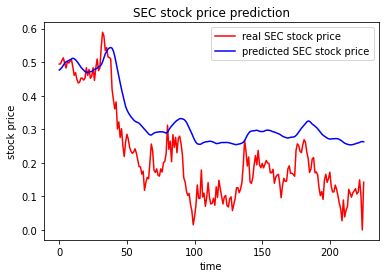

내일 가격 : [17.802658] KRW


In [ ]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

print("내일 가격 :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

테스트 데이터가 2020년 1월 22일까지의 데이터였으므로 pred_y의 마지막 값은 당연히 2020년 1월 23일의 종가입니다. (우리는 10일 치의 OHLV 데이터로부터 '다음날'의 종가를 예측하기 때문입니다.) 즉, pred_y[-1]을 하면 2020년 1월 23일의 예측된 종가라는 것이죠.

**내일 SEC 주가**를 출력한 부분은 2020년 1월 23일의 삼성전자 종가 예측입니다. 삼성전자 종가 예측치 pred_y[-1]은 부동소수형(0과1 사이의 변환된 값)이므로 변환 전의 마지막 날 종가 df.Close[-1]과 변환 후의 마지막 날 종가 dfy.Close[-1]의 관계식


```
df.Close[-1] : dfy.Close[-1] = y : pred_y[-1]
```
을 통해서 예측 가격 y(변환 전의 값)를 구했습니다.

위 결과는 여러분들이 실행할 때마다 결과가 조금씩 달라질 수 있습니다. 왜냐면 딥 러닝 가중치 W와 편향 b가 초기에 랜덤 초기화 된 상태로 시작되기 때문에 여러분들이 실행할 때마다 결과가 조금씩 다릅니다.

이 코드는 딥 러닝으로 주가를 예측하는 아주 간단한 베이스 코드이기때문에 실제로 투자에 사용하기에는 무리가 있고, 여기에 다양한 변수를 추가하면 (+공시 보고서, 뉴스 감성 분석 결과 등)을 더 좋은 예측 성능을 얻을 수 있습니다.